<a href="https://colab.research.google.com/github/srimoyee1212/Whisper-Fairness-Eval/blob/main/Whisper_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating OpenAI WHISPER(Large) For Automatic Speech Recognition

###         Srimoyee Mukhopadhyay (sm2437)


### The below code will use the Speech Accent Archive Dataset and to audit the Whisper v2 (large) model with OpenAI API.

##### I chose Whisper because it is one of the most popular and most widely used ASR systems right now. (More on Whisper further below in the file where I describe the model)

##### I chose this dataset because it contains a lot of detailed demographic data on the speakers that could be contributing factors to how the same speech is detected by the model for speakers of different demographics. (More on the dataset further below in this file where I describe it in detail)

##### Hypothesis 1 : I expect Whisper to perform very well on this dataset because of Whisper's extensive language support.

##### Hypothesis 2 : There could be discrepancies for speakers whose languages do not have sufficient data to train the model when it was developed.

In [ ]:
!pip install openai
!pip install jiwer
!pip install langdetect

In [68]:
import os
from google.colab import drive
from openai import OpenAI
import pandas as pd
import re
import jiwer
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from langdetect import detect
import warnings

In [69]:
warnings.filterwarnings("ignore")

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Loading and pre-processing the dataset

#### The speech accent archive is established to uniformly exhibit a large set of speech accents from a variety of language backgrounds. Native and non-native speakers of English all read the same English paragraph and are carefully recorded.
#### The dataset folder is called Speech-Archive and it contains the following:

- **recordings** folder contains 2140 recordings from the speech (.mp3) archive dataset of speakers (male and female) saying the same thing. Some of these speakers also speak in langauges other than english

- **speakers_all.csv** contains the original dataset of speakers and the following columns:
  - age - age of the speaker
  - age_onset - age when English language was learned
  - birthplace - place of birth
  - filename - name of the audio files in recordings folder
  - native_language - native language of the speaker
  - sex - gender
  - speakerid - speaker unique id
  - country - country of origin
  - file_missing - if the audio file exists or not

- **reading-passage.txt** contains the English paragraph that all speakers read (Ground Truth)

#### The dataset license:  CC BY-NC-SA 2.0 license.
#### This dataset was collected by many individuals (full list here) The dataset was collected legally and ethically under the supervision of Steven H. Weinberger. The most up-to-date version of the archive is hosted by George Mason University.
#### Citation: Weinberger, S. (2013). Speech accent archive. George Mason University.

In [73]:
# read the CSV of all speakers details into a dataframe
data_df = pd.read_csv('/content/drive/MyDrive/Speech-archive/speakers_all.csv')

In [74]:
data_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [75]:
data_df.count()

age                2172
age_onset          2172
birthplace         2168
filename           2172
native_language    2172
sex                2172
speakerid          2172
country            2167
file_missing?      2172
Unnamed: 9            0
Unnamed: 10           0
Unnamed: 11           1
dtype: int64

In [76]:
# Dropped extra columns, rows where file_missing? is True i.e. the audio file is missing from recordings folder, and rows containing any null values
data_df.drop(columns=["Unnamed: 9", "Unnamed: 10", "Unnamed: 11"], inplace=True)

data_df = data_df[data_df["file_missing?"] == False]

data_df.dropna(axis=0, inplace=True)

In [8]:
data_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False


In [9]:
# reading the GROUND TRUTH txt file and appending it to the original dataframe (ground_truth column)
with open('/content/drive/MyDrive/Speech-archive/reading-passage.txt', 'r') as f:

  contents = f.read()

  print(contents)
data_df['ground_truth'] = contents

Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.



In [10]:
data_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,ground_truth
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,Please call Stella. Ask her to bring these th...
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,Please call Stella. Ask her to bring these th...
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,Please call Stella. Ask her to bring these th...
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,Please call Stella. Ask her to bring these th...
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,Please call Stella. Ask her to bring these th...


In [11]:
data_df.count()

age                2135
age_onset          2135
birthplace         2135
filename           2135
native_language    2135
sex                2135
speakerid          2135
country            2135
file_missing?      2135
ground_truth       2135
dtype: int64

In [12]:
# saving the final modified dataframe containing all relevant rows and columns and also the ground_truth column containing the paragraph that all speakers read
data_df.to_csv('/content/drive/My Drive/Speech-archive/data_df.csv', index=False)

In [16]:
# as the data is too large and consumes significant resources and cost for the model to run, I am removing audio files per language if there are more than 5. For example there are 9 recordings for albanian speakers, this code will retain only 5.
pattern=r'([A-Za-z]+)(\d+).mp3'
source_directory = '/content/drive/My Drive/Speech-archive/recordings/'
# also created a new folder to keep the new speech data containing lesser number of files. This will be used finally to test the model.
target_directory = '/content/drive/My Drive/Speech-archive/recordings-modified/'

shutil.copytree(source_directory, target_directory)

os.chdir(target_directory)

mp3_files = [f for f in os.listdir()]

for files in mp3_files:
    match1 = re.search(pattern, files)

    if match1:
        file_num = match1.group(2)
        if int(file_num) > 5:
            os.remove(files)

In [19]:
os.environ['OPENAI_API_KEY'] = '#hidden key for submission'
client = OpenAI()

### Model Details

#### I am using OpenAI Whisper through an API call. The Whisper models are trained for speech recognition and translation tasks, capable of transcribing speech audio into the text in the language it is spoken (ASR) as well as translated into English (speech translation). I am using large-v2 Whisper model.

#### As the dataset is about 4 years older, I expect Whisper to perform exceptionally well on this dataset.

In [ ]:
os.chdir(target_directory)
mp3_files = [f for f in os.listdir()]
results_df = pd.DataFrame(columns=['filename', 'transcription'])

for file in mp3_files:
  with open(file, 'rb') as audio_file:
    transcription = client.audio.transcriptions.create(
      model="whisper-1",
      file=audio_file,
      response_format="text"
    )
    audio_file_name = os.path.splitext(file)[0]
    results_df = results_df.append({'filename': audio_file_name, 'transcription': transcription}, ignore_index=True)

In [21]:
results_df.head()

,filename,transcription
0,hebrew4,Please call Stella. Ask her to bring these thi...
1,hausa4,Umayeri jele Satela siuku haletu tuji leapati ...
2,hebrew5,Please call Stella. Ask her to bring these thi...
3,hausa5,Please call Stella. Ask her to bring these thi...
4,hungarian3,"Please call Stella, ask her to bring these thi..."


In [22]:
results_df.to_csv('/content/drive/My Drive/Speech-archive/results_df.csv', index=False)

In [42]:
results_df.count()

filename         560
transcription    560
dtype: int64

In [46]:
# as shown above some transcriptions are in languages not in English (this is because of speakers are speaking this paragraph in their own language).
#Because we only have the ground_truth in English, I will detect which transcriptions are in English first.
results_df['language detected'] = results_df['transcription'].apply(lambda x: detect(x) if pd.notnull(x) else None)


In [47]:
results_df.head()

,filename,transcription,language detected
0,hebrew4,Please call Stella. Ask her to bring these thi...,en
1,hausa4,Umayeri jele Satela siuku haletu tuji leapati ...,sw
2,hebrew5,Please call Stella. Ask her to bring these thi...,en
3,hausa5,Please call Stella. Ask her to bring these thi...,en
4,hungarian3,"Please call Stella, ask her to bring these thi...",en


In [48]:
# Now I will create a new dataframe to only contain the transcriptions that are in English
results_english_only = results_df[results_df['language detected'] == 'en'].copy()
results_english_only.to_csv('/content/drive/My Drive/Speech-archive/results_english_only.csv', index=False)

#results_english_only = results_english_only.drop(columns=['detected_language'])

In [78]:
results_english_only.head()

,filename,transcription,language detected
0,hebrew4,Please call Stella. Ask her to bring these thi...,en
2,hebrew5,Please call Stella. Ask her to bring these thi...,en
3,hausa5,Please call Stella. Ask her to bring these thi...,en
4,hungarian3,"Please call Stella, ask her to bring these thi...",en
5,hindi4,Please call Stella. Ask her to bring these thi...,en


In [49]:
# I will now merge the dataframe containing the English transcriptions with the original dataframe that contains ground truth in english
merged_df = pd.merge(data_df, results_english_only, how='inner', on=['filename'])

In [50]:
merged_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,ground_truth,transcription,language detected
0,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,Please call Stella. Ask her to bring these th...,"Please call Stella, ask her to bring these thi...",en
1,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...,en
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...,en
3,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...,en
4,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,Please call Stella. Ask her to bring these th...,"Please call Stella, ask her to bring these thi...",en


In [51]:
merged_df.to_csv('/content/drive/My Drive/Speech-archive/merged_df.csv', index=False)

In [52]:
merged_df.count()

age                  511
age_onset            511
birthplace           511
filename             511
native_language      511
sex                  511
speakerid            511
country              511
file_missing?        511
ground_truth         511
transcription        511
language detected    511
dtype: int64

### Calculating Word Error Rate as a Metric of Evaluation

##### WER measures the difference between reference (or ground truth) transcription and the output transcription generated by a system.

In [53]:
ground_truth_list = merged_df['ground_truth'].astype(str).tolist()
transcription_list = merged_df['transcription'].astype(str).tolist()
# Here I am calculating the WER for each row
wer_list = [jiwer.wer(gt, tr) for gt, tr in zip(ground_truth_list, transcription_list)]


merged_df['WER'] = wer_list


merged_df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,ground_truth,transcription,language detected,WER
0,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,False,Please call Stella. Ask her to bring these th...,"Please call Stella, ask her to bring these thi...",en,0.086957
1,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,False,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...,en,0.057971
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,False,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...,en,0.043478
3,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,False,Please call Stella. Ask her to bring these th...,Please call Stella. Ask her to bring these thi...,en,0.043478
4,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,False,Please call Stella. Ask her to bring these th...,"Please call Stella, ask her to bring these thi...",en,0.144928


### WER per native language

In [54]:
# calculating average WER for each language
average_wer_per_language = merged_df.groupby('native_language')['WER'].mean().reset_index()

In [55]:
average_wer_per_language.head()

,native_language,WER
0,afrikaans,0.075362
1,agni,0.101449
2,akan,0.130435
3,albanian,0.098551
4,amazigh,0.130435


In [77]:
# sorting the values
average_wer_per_language = average_wer_per_language.sort_values(by='WER')
average_wer_per_language.head()

,native_language,WER
148,shona,0.021739
42,faroese,0.028986
16,bavarian,0.028986
27,chamorro,0.028986
130,pohnpeian,0.028986


In [58]:
low_wer_language = average_wer_per_language.head(10).copy()

In [59]:
high_wer_language = average_wer_per_language.tail(10).copy()

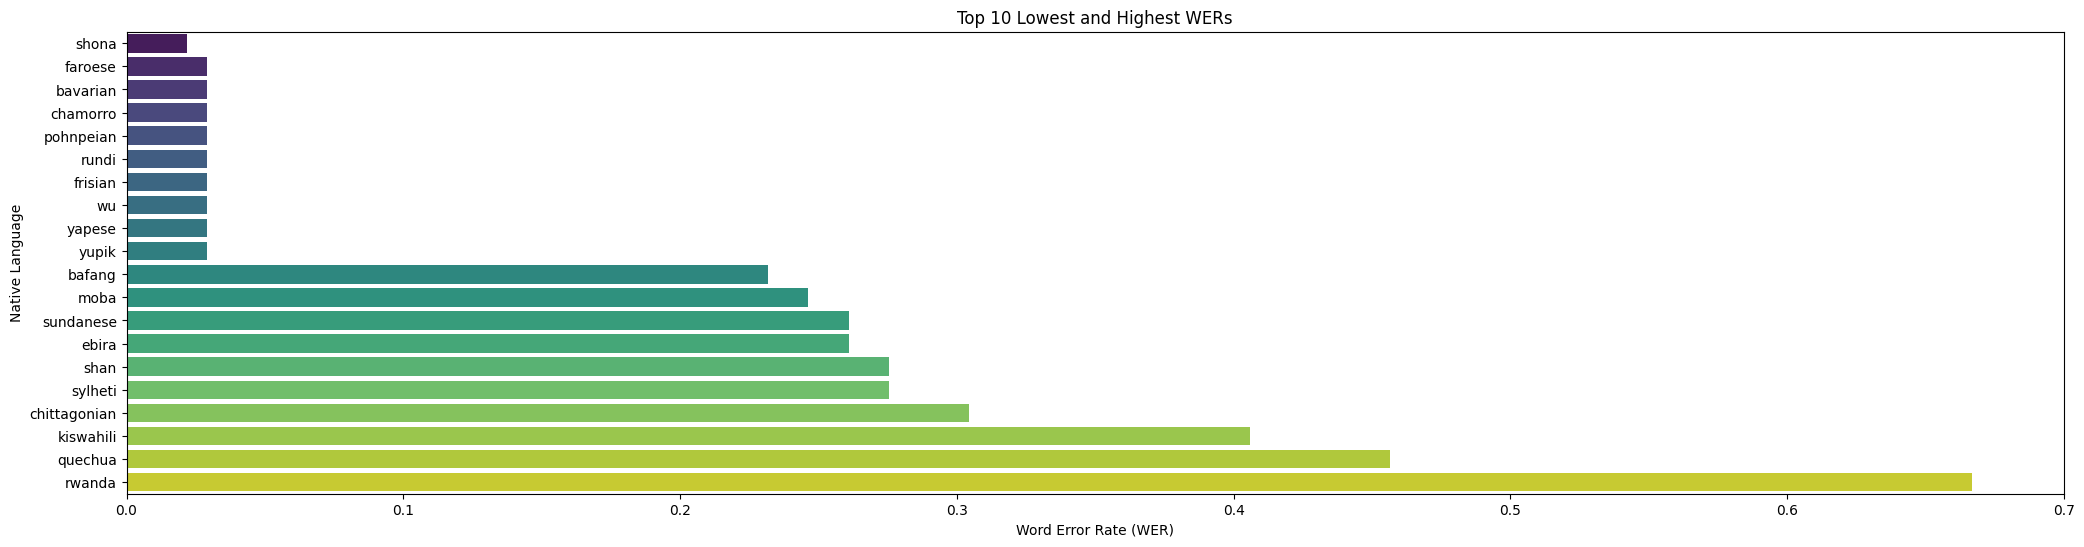

In [70]:
plot_data = pd.concat([low_wer_language, high_wer_language])

plt.figure(figsize=(25, 6))
sns.barplot(x='WER', y='native_language', data=plot_data, palette='viridis')

plt.xlabel('Word Error Rate (WER)')
plt.ylabel('Native Language')
plt.title('Top 10 Lowest and Highest WERs')

plt.show()

### WER per gender

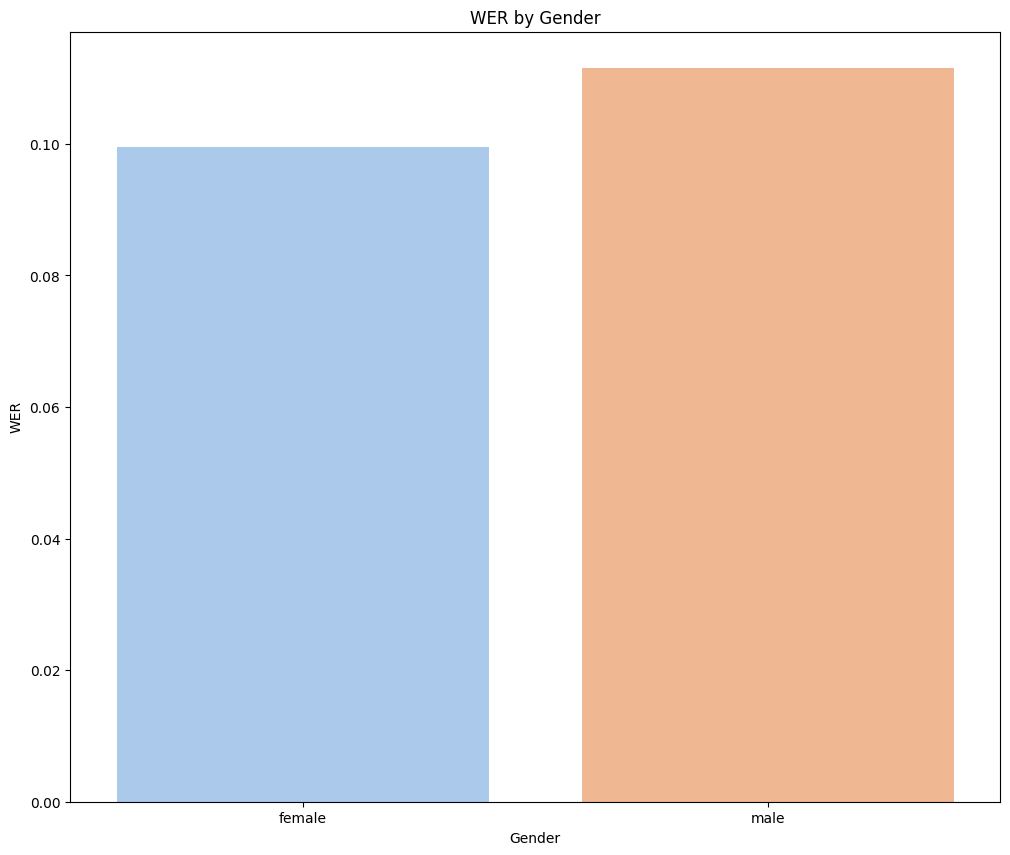

In [79]:
# calculating the mean WER for each gender (this dataset has binary genders only)
average_wer_per_gender = merged_df.groupby('sex')['WER'].mean().reset_index()
plt.figure(figsize=(12, 10))
sns.barplot(x='sex', y='WER', data=average_wer_per_gender, palette='pastel')
plt.xlabel('Gender')
plt.ylabel('WER')
plt.title('WER by Gender')
plt.show()

In [80]:
average_wer_per_gender.head()

,sex,WER
0,female,0.099483
1,male,0.111474


In [82]:
wer_female = average_wer_per_gender.loc[average_wer_per_gender['sex'] == 'female', 'WER'].values[0]
wer_male = average_wer_per_gender.loc[average_wer_per_gender['sex'] == 'male', 'WER'].values[0]

percentage_difference = ((wer_male - wer_female) / wer_female) * 100

print(f"The WER of males is {percentage_difference:.2f}% higher than females.")

The WER of males is 12.05% higher than females.


##**Analysis**

#### As hypothesized in the start, Whisper performs excellently for this dataset. I grouped the mean WER rates by native language and gender. I used these two comparisons as I wanted to understand how native language, accent and pronunciation affect speech recognition and also how gender is a factor in speech recognition.

#### Even the speakers with most obscure native languages have a surprisingly low WER(better speech recognition) when speaking in English. Probable causes for this could be that because these speakers do not natively speak or use English routinely, their spoken English is not marred by colloquial irregularities that some native English speakers may inculcate into their speech.  

#### Another interesting thing to note is how the average WER rates vary across genders. Since females are historically underrepresented and a lot of other applications such as vision are biased against females, I expected this to follow that pattern. But very surprisingly females have a lower WER compared to males. But reviewing relevant literature I see that the WER is mostly always lower for females than males (by ~2.6% for English language, source: [link text](https://shorturl.at/hBDHK)) and Whisper's speech recognition matches this pattern.